# G06: Class Activation Map
### CAM과 Grad-CAM을 구현해보자
#### 루브릭
1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?   
ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.
2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?   
CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.
3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?   
CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

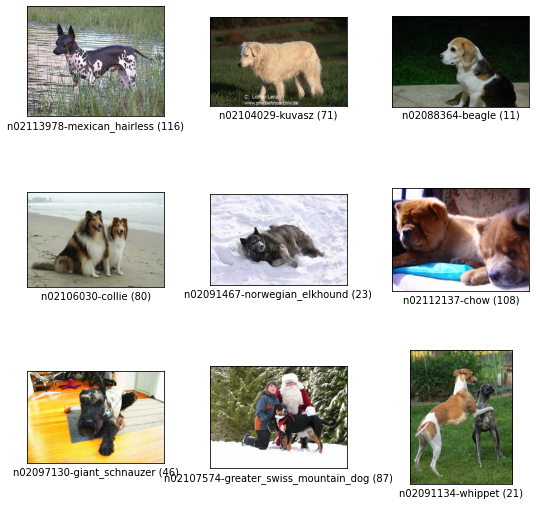

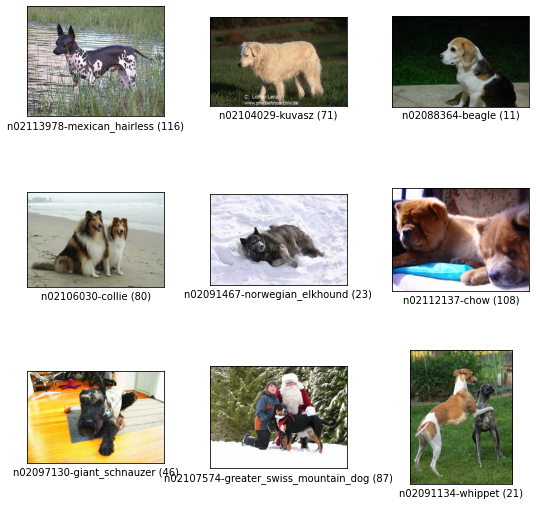

In [3]:
tfds.show_examples(ds_test, ds_info)

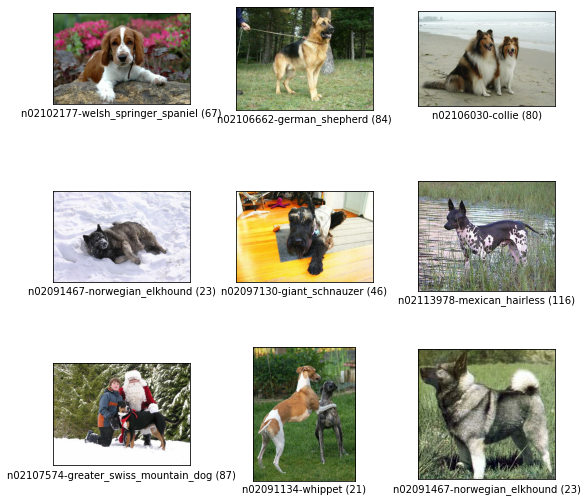

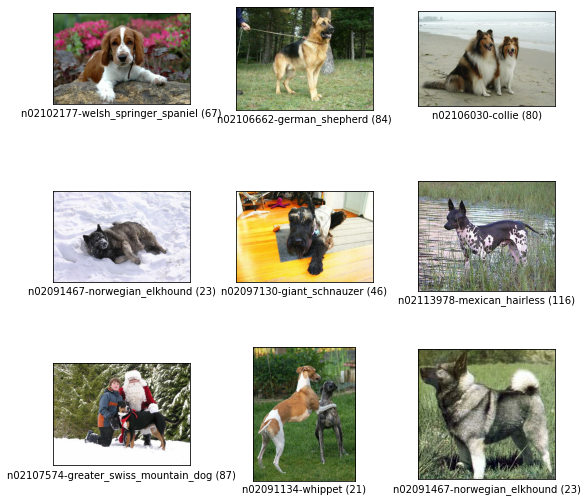

In [4]:
tfds.show_examples(ds_test, ds_info)

In [5]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

## 1-1. 모델 만들기: CAM

In [6]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

- 기존 classification 모델과 다른 점: 마지막 fully connected layer 대신 GAP을 사용하였다.
- 방법: ResNet50의 매개변수 pooling에 'avg'를 매개변수로 전달


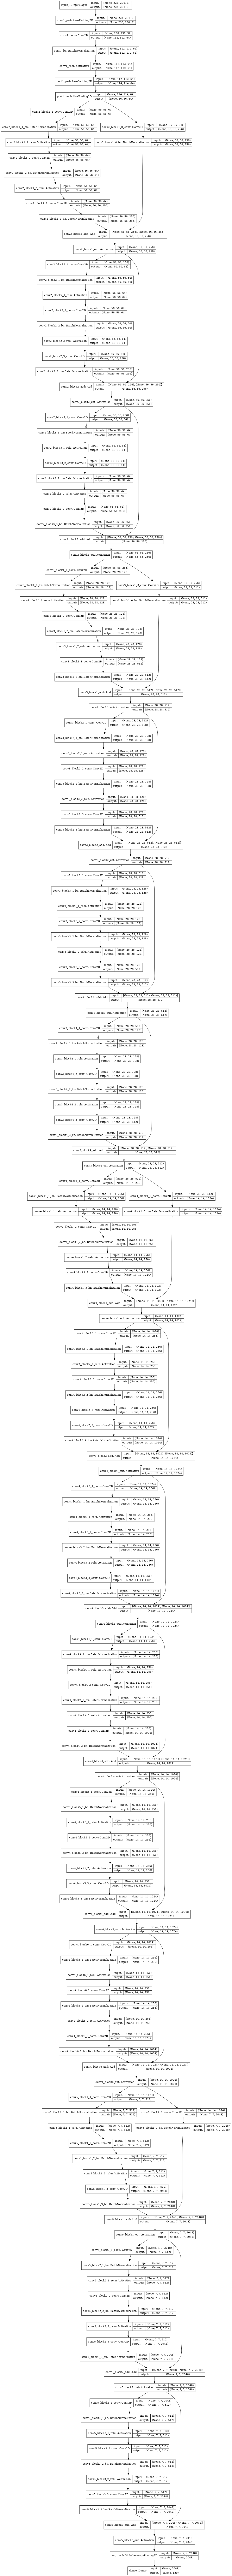

In [7]:
tf.keras.utils.plot_model(cam_model, show_shapes=True, dpi=64)

- average pooling 부분에 fully connected layer 대신 GAP(Global Average Pooling2D)를 사용한 것을 위의 그림에서 확인할 수 있다.

## 1-2. 모델 학습하기: CAM

In [8]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [10]:
tf.random.set_seed(12725)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [11]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 1569s 2s/step - loss: 3.1693 - accuracy: 0.2830 - val_loss: 3.4490 - val_accuracy: 0.2091
Epoch 2/15
750/750 [==============================] - 1523s 2s/step - loss: 0.8693 - accuracy: 0.7602 - val_loss: 1.0198 - val_accuracy: 0.6982
Epoch 3/15
750/750 [==============================] - 1522s 2s/step - loss: 0.2742 - accuracy: 0.9389 - val_loss: 0.9219 - val_accuracy: 0.7291
Epoch 4/15
750/750 [==============================] - 1522s 2s/step - loss: 0.0736 - accuracy: 0.9924 - val_loss: 0.8890 - val_accuracy: 0.7399
Epoch 5/15
750/750 [==============================] - 1522s 2s/step - loss: 0.0305 - accuracy: 0.9980 - val_loss: 0.9099 - val_accuracy: 0.7449
Epoch 6/15
750/750 [==============================] - 1522s 2s/step - loss: 0.0161 - accuracy: 0.9997 - val_loss: 0.9352 - val_accuracy: 0.7387
Epoch 7/15
750/750 [==============================] - 1522s 2s/step - loss: 0.0124 - accuracy: 0.9998 - val_loss: 0.9511 - val_accuracy:

- 학습된 가중치를 저장해준다.

In [12]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)

In [13]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

- get_one() 함수로 데이터셋에서 한 장씩 뽑아주는 이유:   
 - CAM 생성 작업이 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문이다.

In [14]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

- 데이터 준비

71


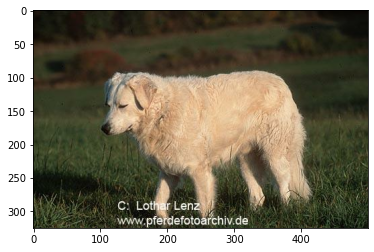

In [15]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

-  CAM을 생성하기 위해 이전 스텝에서 학습한 모델을 불러와 보자.

In [16]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

CAM을 생성하기 위해서는 (1) 특성 맵, (2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치, 그리고 (3) 원하는 클래스의 출력값이 필요합니다. 또 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화해야 할 것입니다. 이를 고려해서 model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 합니다.

generate_cam() 을 구현하기 위해 아래에서는 conv_ouputs와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, feedforward를 거친 후 CAM을 계산하도록 구현하였습니다. 마지막에는 입력 이미지의 크기에 맞춰 CAM을 resize해 주었습니다.

#### CAM 생성

In [17]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

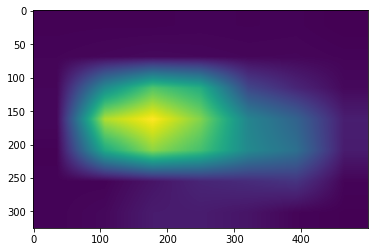

In [18]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

- CAM 이미지를 원본 이미지와 합침으로써 사진에서 강아지의 특징 중 어느부분이 중요하다고 판단했는지 알아보자.
-  visualize_cam_on_image() 함수: 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정함으로써 하나의 이미지에서 원본과 CAM을 겹쳐 보여준다.

In [19]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

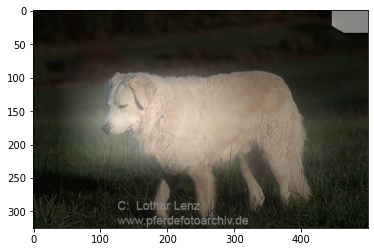

In [20]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

In [22]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

NameError: name 'grad_cam_image' is not defined

# 2-1 모델 만들기: Grad_CAM

- CAM 함수와 Grad-CAM의 차이점: Grad-CAM은 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록 activation_layer의 이름을 받고 이를 활용해야 한다.

- generate_grad_cam(): 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용한다.

In [23]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

- 각 layer의 CAM 이미지를 뽑아서 layer를 거듭할수록 어떻게 이미지의 특징을 뽑아주는지 확인해보자.

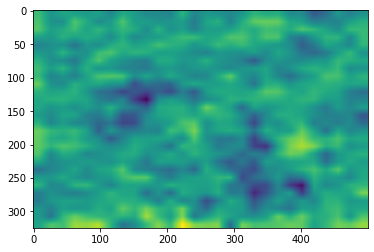

In [24]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

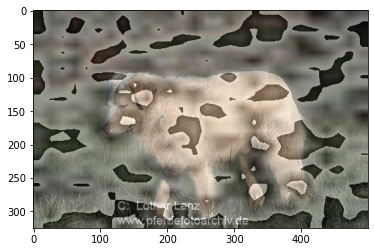

In [25]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_conv3 = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_conv3, origin_image)
plt.imshow(blended_image)
plt.show()

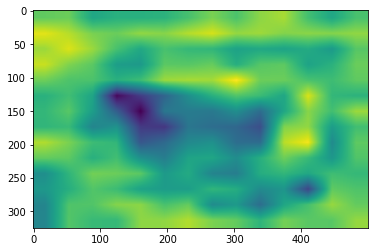

In [26]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

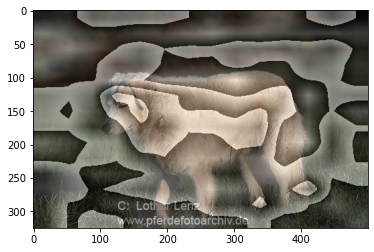

In [27]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_conv4 = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_conv4, origin_image)
plt.imshow(blended_image)
plt.show()

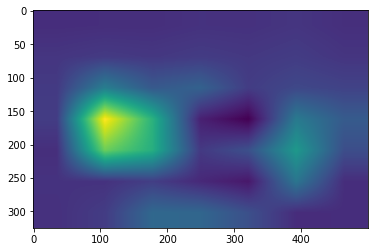

In [28]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

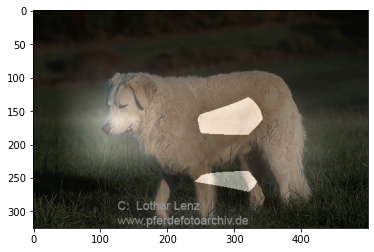

In [29]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_conv5 = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_conv5, origin_image)
plt.imshow(blended_image)
plt.show()

- Layer를 거듭할수록 자잘자잘한 디테일에 신경쓰기보단, 특징이 뚜렷한 부위에 집중해서 특징을 잡아주고 있는 것을 확인할 수 있다.
- conv3 layer에선 어느 부분에 강아지의 특징이 있는지 아예 파악을 못해줬다는 것을 확인하였다.

## 3. Detection with CAM

In [30]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [31]:
rect = get_bbox(cam_image)
rect

array([[ 39,  72],
       [499,  72],
       [499, 324],
       [ 39, 324]])

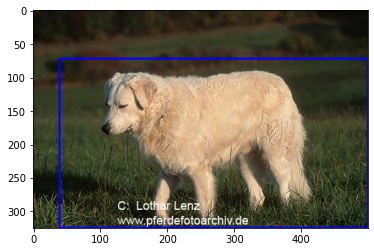

In [32]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

## 4. Detection with Grad-CAM

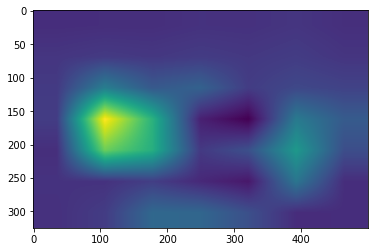

In [33]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

In [34]:
image = copy.deepcopy(item['image'])
grad_rect = get_bbox(grad_cam_image)
grad_rect

array([[  0, 324],
       [  0,  59],
       [499,  59],
       [499, 324]])

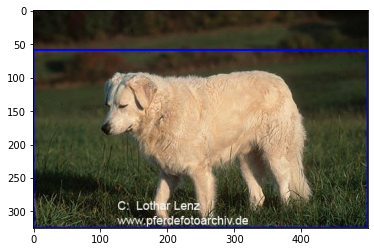

In [35]:
image = cv2.drawContours(image,[grad_rect],0,(0,0,255),2)
plt.imshow(image)

## 5. IOU: Intersection Over Union
: 정답 데이터인 바운딩 박스와 이를 어떻게 비교, 평가할 수 있는 기준

In [36]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

- Ground Truth

In [37]:
item['objects']['bbox']

array([[0.27384615, 0.2       , 0.9969231 , 0.836     ]], dtype=float32)

- CAM

In [38]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.22153846153846155, 0.078, 0.9969230769230769, 0.998]

- Grad-CAM

In [39]:
grad_pred_bbox = rect_to_minmax(grad_rect, item['image'])
grad_pred_bbox

[0.18153846153846154, 0.0, 0.9969230769230769, 0.998]

- CAM 추론 결과로 얻어진 bbox가 ground truth bbox가 얼마나 유사한지를 IoU를 계산해서 확인해보자

In [40]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [41]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.6446687770709205

In [42]:
get_iou(grad_pred_bbox, item['objects']['bbox'][0])

0.5651302957699522

#### 회고

|CAM|Grad-CAM|
|---|--------|
|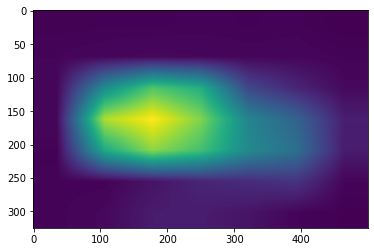|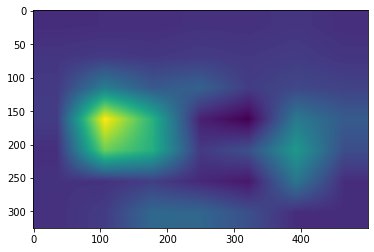|
|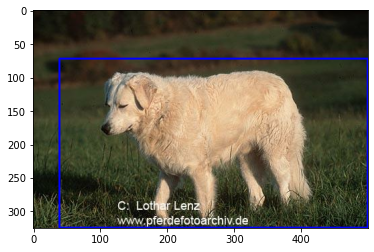|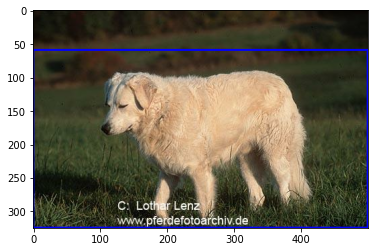|

- CAM과 Grad-CAM의 IOU를 비교해보면 CAM의 경우 0.6446687770709205, Grad-CAM의 경우 0.5651302957699522로 CAM의 성능이 더 좋다. 
- CAM의 성능이 왜 좋은지 추측해보면 일단 bounding bound를 비교해보면 CAM의 경우 강아지 외의 부분이 적어서 Grad-CAM보다 강아지의 부분을 잘 잡아준 것을 확인할 수 있다.
- 또한 CAM이 Grad-CAM보다 강하게 활성화된 부분이 넓은 것으로 보아 더 많은 디테일에 주목했다는 것을 알 수 있다.
- Grad-CAM은 전체적으로 뿌옇다. 따라서 중요 부분이 어느 부분인지 잘 학습이 되지 않았다.
- 결론적으로 Grad-CAM CAM에 비해 다양한 모델에 적용할 수 있다는 이점이 있으나 성능면에서는 비교적 안좋다.